Ключевые темы:

*   Многоклассовая классификация
*   Калибровка веротяностей



Дополнительный темы (будут затронуты, можно будет поизучать самим):
*   Pipeline
*   Отбор признаков
*   Сэмплинг
*   Kaggle



# Классификация для n классов

## Как совладать с небинарной классификацией

В течение всего 3го модуля мы в основном занимались задачами классификации с двумя классами. Пришло время узнать больше о небинарной классификации.
Вспомним, какие методы машинного обучения мы уже успели пройти.
 * Какие из пройденных методов не требуют адаптации для multiclass?
 * Какие из них скорее всего покажут себя плохо?
 * Какие из пройденных методов потребуют адаптации и что можно предложить?

## Новый взгляд на логистическую регрессию

__multi_class{‘auto’, ‘ovr’, ‘multinomial’}__
* ovr: One-vs-rest. Это означает k бинарных (binomial) задач логистической регрессии для k классов (i vs not i), используется log loss. Подумайте, какие возможны модификации (ovo)?
* multinomial: cross-entropy loss. Исходя из принципа независимости выбора (выбор между A и B не зависит от C, что может быть не всегда верным), мы рассматриваем все случаи вместе.

Рассмотрим метку класса так в виде one-hot вектора. Т.е., если мы должны отнести объект к классу 0, 1 или 2, обозначим их как [1, 0, 0], [0, 1, 0] и [0, 0, 1] соответственно. Допустим, для очередного объекта, принадлежащего классу 0, модель выдаст вероятности [0.5, 0.3, 0.2]. В таком случае loss для это просто отрицательная сумма по $i$: $ -p(i) * log(q(i)) $, где $p(i)$ -- это i-ое значение в целевом one-hot векторе, а $q(i)$ -- это i-ое значение в предсказанном наборе вероятностей.

Пока мы рассматриваем однозначную принадлежность к одному из классов, все слагаемые, кроме одного, занулятся, итого loss будет равен $-log(q(i))$.

Такой подход также позволяет легко перейти к задаче, где мы допускаем, что объект относится сразу к нескольким классам. Например, задача классификации токсичных комментариев. Мы можем присвоить комментарию сразу несколько плашек (или ни одной) из набора {threats, insults, hate speech}.

Сравним ovr и multinomial на "практике". Как вы думаете, какой из подходов справится лучше c классификацией кластеров центрированных Гауссовых пучков?

training score : 0.995 (multinomial)
training score : 0.976 (ovr)


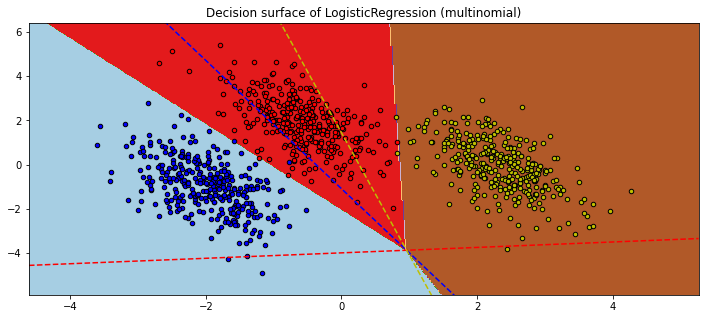

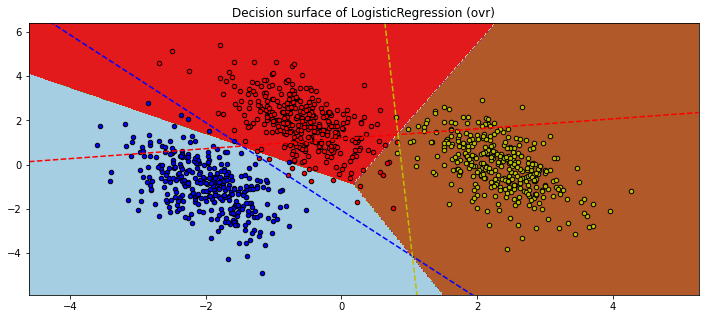

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

%matplotlib inline

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multi_class).fit(X, y)
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

## Возвращаемся к текстам
Перейдём к более реальным примерам. Рассмотрим multiclass классификацию на датасете от StackOverflow. Будем распознавать язык программирования по посту. Воспользуемся возможностью google BigQuery для запроса датасета.
(Впрочем, на семинаре лучше пользоваться готовым https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/ws11-multi-competitions/stackoverflow-data.csv)

In [2]:
# Можно делать вот так:

# rgxp = r'["\n\'?,]|<p>|</p>'
# query = '''SELECT post, tags FROM (
#   SELECT 
#     TRIM(LOWER(REGEXP_REPLACE(CONCAT(title, ' ', body), \'''' + rgxp + '''\'," "))) as post, 
#     tags,
#     row_number() over(partition by tags) row_num
#   FROM `bigquery-public-data.stackoverflow.posts_questions` a
#   WHERE tags IN ("javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios", "css", "mysql", "sql", "asp.net", "ruby-on-rails", "objective-c", "c", ".net", "angularjs", "iphone"))
# WHERE row_num <= 2000
# ORDER BY RAND()'''

# df = pd.read_gbq(query, project_id='...')

In [3]:
# Но мы будем делать так:

df = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/ws11-multi-competitions-data/stackoverflow-data.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

   Unnamed: 0                                               post  \
0           0  aspnet web form navigation  i want to redirect...   
1           1  can t pass instance to the view letsrate gem r...   
2           2  how can i best perform this kinda of table rel...   
3           3  forking multiple times  so this is a snippet o...   
4           4  why does this select ... in statement not work...   
5           5  how to get the url the client used  in asp.net...   
6           6  how to fetch funnhub fetch realtime stock deta...   
7           7  why aren t my global variables seeming to chan...   
8           8  how can i decrypt this encrypting method in ph...   
9           9  div positioning varies when runat= server   ha...   

            tags  
0        asp.net  
1  ruby-on-rails  
2          mysql  
3              c  
4          mysql  
5        asp.net  
6         python  
7            c++  
8            php  
9           html  
11324398


Почистим текст

In [4]:
from bs4 import BeautifulSoup
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)
df['post'].apply(lambda x: len(x.split(' '))).sum()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/narekalvandan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3713685

Разделим признаки и целевую переменную:

In [5]:
from sklearn.model_selection import train_test_split

X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [6]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)), # might need max_iter up to 1000 to converge
                  ])
logreg.fit(X_train, y_train)

lg_y_pred = logreg.predict(X_test)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 3min 30s, sys: 39.6 s, total: 4min 10s
Wall time: 40.2 s


In [7]:
print(classification_report(y_test, lg_y_pred))
lg_proba = logreg.predict_proba(X_test)
print(lg_proba[0])
print(lg_y_pred[0])

               precision    recall  f1-score   support

         .net       0.71      0.70      0.71       564
      android       0.92      0.89      0.90       582
    angularjs       0.96      0.97      0.96       613
      asp.net       0.79      0.75      0.77       589
            c       0.87      0.83      0.85       628
           c#       0.64      0.69      0.67       628
          c++       0.83      0.84      0.83       606
          css       0.86      0.84      0.85       630
         html       0.70      0.75      0.72       604
          ios       0.64      0.65      0.64       554
       iphone       0.66      0.71      0.68       572
         java       0.87      0.84      0.86       596
   javascript       0.79      0.79      0.79       570
       jquery       0.87      0.88      0.87       629
        mysql       0.84      0.79      0.82       588
  objective-c       0.74      0.69      0.72       625
          php       0.86      0.85      0.86       587
       py

## SGDClassifier

In [8]:
%%time

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

CPU times: user 6.93 s, sys: 1.18 s, total: 8.11 s
Wall time: 3.01 s


In [9]:
print(classification_report(y_test, sgd_y_pred))
sgd_proba = sgd.predict_proba(X_test)
print(sgd_proba[0])
print(sgd_y_pred[0])

               precision    recall  f1-score   support

         .net       0.76      0.69      0.72       564
      android       0.92      0.91      0.91       582
    angularjs       0.96      0.94      0.95       613
      asp.net       0.80      0.78      0.79       589
            c       0.86      0.84      0.85       628
           c#       0.72      0.66      0.69       628
          c++       0.83      0.80      0.82       606
          css       0.80      0.92      0.85       630
         html       0.75      0.74      0.74       604
          ios       0.68      0.65      0.66       554
       iphone       0.74      0.70      0.72       572
         java       0.89      0.85      0.87       596
   javascript       0.78      0.80      0.79       570
       jquery       0.87      0.86      0.86       629
        mysql       0.82      0.80      0.81       588
  objective-c       0.74      0.73      0.73       625
          php       0.87      0.86      0.87       587
       py

Можно заметить, что разные методы дают значительно различающиеся наборы вероятностей даже при одинаковом результате предсказания. Как мы обсудили раньше, вероятности можно использовать для обучения, поэтому их конкретные значения могут играть немаленькую роль.

Кроме того, они могут пригодиться для интерпретации модели и комплексной оценки качества с повышенной уверенностью. Наконец, в более сложных пайплайнах вероятности могут иметь прямое влияние на последующие алгоритмы, использующие выход модели.

* Как бы вы оценили, хорошо ли модель выдаёт вероятности?

## Калибровка предсказанных вероятностей

Классификатор считается хорошо откалиброванным, если среди группы объектов, по которой средняя вероятность для лейбла $K$ равна p (допустим, ~0.7), количество объектов, действительно принадлежащих классу $K$ -- как раз примерно p (0.7). (Рассматривается не произвольная группа объектов, а именно такая, на которой вероятность для лейбла $K$ лежит, допустим, в границах 0.65  <= p <= 0.75.)

In [50]:
def estimate_prob_vs_label(proba, labels, value, eps=0.01):
    counter, iphone = 0, 0
    
    iphone_label = 'iphone'
    iphone_label_i = 10

    for probs, label in zip(proba, labels):
        if value - eps < probs[iphone_label_i] and probs[iphone_label_i] < value + eps:
            counter += 1
            if iphone_label in label:
                iphone += 1
        
    print(f"True prob: {value:.2f}, Estimated prob: {iphone / counter:.2f}")
    return iphone / counter

- LogReg
True prob: 0.05, Estimated prob: 0.00
True prob: 0.10, Estimated prob: 0.00
True prob: 0.15, Estimated prob: 0.00
True prob: 0.20, Estimated prob: 0.00
True prob: 0.25, Estimated prob: 0.00
True prob: 0.30, Estimated prob: 0.00
True prob: 0.40, Estimated prob: 0.17
True prob: 0.45, Estimated prob: 0.40
True prob: 0.50, Estimated prob: 0.71
True prob: 0.55, Estimated prob: 1.00
True prob: 0.60, Estimated prob: 1.00
True prob: 0.65, Estimated prob: 1.00
True prob: 0.70, Estimated prob: 1.00
True prob: 0.75, Estimated prob: 1.00
True prob: 0.80, Estimated prob: 1.00
True prob: 0.85, Estimated prob: 1.00
True prob: 0.90, Estimated prob: 1.00
- SGD
True prob: 0.05, Estimated prob: 0.00
True prob: 0.10, Estimated prob: 0.01
True prob: 0.15, Estimated prob: 0.08
True prob: 0.20, Estimated prob: 0.08
True prob: 0.25, Estimated prob: 0.32
True prob: 0.30, Estimated prob: 0.49
True prob: 0.35, Estimated prob: 0.82
True prob: 0.40, Estimated prob: 0.88
True prob: 0.45, Estimated prob: 0.

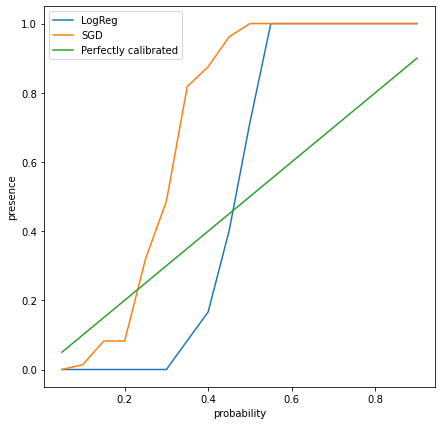

In [53]:
plt.figure(figsize=(7,7))
for proba, labels, label_name in zip([lg_proba, sgd_proba], \
                                     [lg_y_pred, sgd_y_pred], \
                                     ['LogReg', 'SGD']):
    
    print('-', label_name)
    values, presence = [], []
    for i in np.arange(0.05, 0.95, 0.05):
        try:
            presence.append(estimate_prob_vs_label(proba, labels, i))
        except ZeroDivisionError:  # случай, когда у нас не было предсказанных вероятностей равных i
            continue
        
        values.append(i)
    plt.plot(values, presence, label = label_name)

plt.plot(values, values, label = 'Perfectly calibrated')
plt.xlabel('probability')
plt.ylabel('presence')
plt.legend()
plt.show()

Как мы видим, обученные нами классификаторы в задаче про stackoverflow сложно назвать хорошо откалиброваными. Однако для multiclass ситуация несколько сложнее. Поэтому для демонстрации "балансировки" вернемся к бинарной классификации.

Рассмотрим вопрос калибровки на примере хорошо известной нам задачи кредитного скоринга с бинарной классификацией.

In [54]:
dataset = pd.read_csv("https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw03-EDA-data/german_credit.csv")
dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,2-3,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good


In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
for x in dataset.columns:
    if dataset[x].dtype == 'object':
        dataset[x] = LabelEncoder().fit_transform(dataset[x])

dataset["age"] = pd.cut(dataset.age, (18, 25, 35, 50, 65, 80), labels=[0, 1, 2, 3, 4])
dataset["amount"] = pd.cut(dataset.amount, (250, 1000, 2000, 4000, 8000, 20000), labels=[0, 1, 2, 3, 4])
dataset["duration"] = pd.cut(dataset.duration, (4, 6, 8, 12, 18, 24, 36, 48, 72), labels=[0, 1, 2, 3, 4, 5, 6, 7])
dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,3,3,0,2,1,4,2,2,0,2,...,1,0,1,0,0,1,0,0,0,1
1,3,2,0,5,2,4,0,1,3,2,...,3,2,1,0,1,1,1,0,0,1
2,0,2,4,8,0,0,1,1,0,2,...,3,0,1,0,0,3,0,0,0,1


In [57]:
X = dataset.drop(['credit_risk'], 1)
y = dataset['credit_risk']

In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)

rate = pd.DataFrame(fs.scores_, X.columns, columns=['score'])
rate = rate.sort_values('score', axis=0)
rate

,score
people_liable,0.009071
employment_duration,0.079635
installment_rate,0.126847
present_residence,0.155848
amount,0.428326
other_debtors,0.807899
job,1.071934
telephone,1.328891
number_credits,2.091652
duration,2.588473


In [59]:
cols = rate.index.values[::-1]
features = X[[col for col in cols[:len(cols) // 2]]]

Synthetic Minority Over-sampling Technique (SMOTE) - алгоритм, с помощью которого можно "добрать" недостающих обьектов класса, чтобы выборка была сбалансированой.

In [37]:
# !pip install smote-variants
from smote_variants import SMOTE
smote = SMOTE()

In [38]:
X_smote, y_smote = smote.sample(features.values, y.values)
print("Before SMOTE:")
print(y.value_counts())
print("After SMOTE:")
print(np.unique(y_smote, return_counts=True))

2022-04-27 09:20:42,712:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Before SMOTE:
1    700
0    300
Name: credit_risk, dtype: int64
After SMOTE:
(array([0, 1]), array([700, 700]))


In [39]:
print("X_smote shape:", X_smote.shape)
print("y_smote shape:", y_smote.shape)

X_smote shape: (1400, 10)
y_smote shape: (1400,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=11)

In [41]:
lglin = LogisticRegression(solver='liblinear')
lglin.fit(X_train, y_train)
lglin_y_pred = lglin.predict(X_test)

In [42]:
print(classification_report(y_test, lglin_y_pred))

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       131
           1       0.67      0.60      0.63       149

    accuracy                           0.63       280
   macro avg       0.63      0.63      0.63       280
weighted avg       0.63      0.63      0.63       280



In [43]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', decision_function_shape='ovo', probability=True)  # one vs one
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)

In [44]:
print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       0.66      0.80      0.72       131
           1       0.79      0.64      0.70       149

    accuracy                           0.71       280
   macro avg       0.72      0.72      0.71       280
weighted avg       0.73      0.71      0.71       280



In [45]:
svm = SVC(kernel="poly", degree=8, probability=True)
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)

In [46]:
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       131
           1       0.80      0.79      0.79       149

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.78       280
weighted avg       0.78      0.78      0.78       280



In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [48]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       131
           1       0.85      0.70      0.76       149

    accuracy                           0.77       280
   macro avg       0.78      0.78      0.77       280
weighted avg       0.78      0.77      0.77       280



Для бинарной классификации sklearn поможет нам построить нормальную кривую вероятностей (calibration curve).

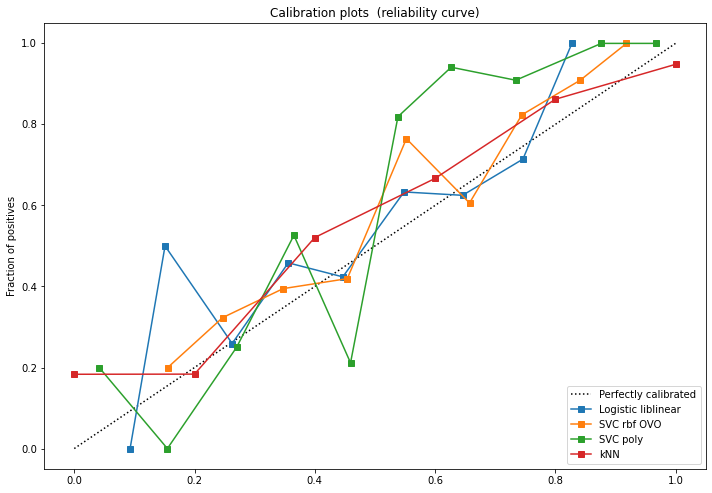

In [49]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name in [(lglin, 'Logistic liblinear'),
                  (svc, 'SVC rbf OVO'),
                  (svm, 'SVC poly'),
                  (knn, 'kNN')]:
    clf.fit(X_train, y_train)
    prob_pos = clf.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')
plt.tight_layout()
plt.show()

Результаты говорят сами за себя.

Вопрос: можно ли как-то откалибровать вероятности и стать более уверенным в этих предсказаниях?



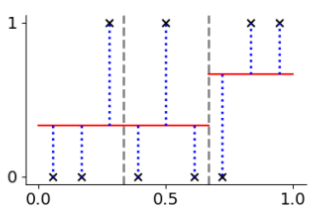

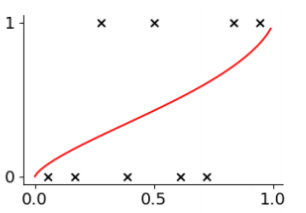

Ответ: да! Давайте разберём основные методы: изотоническую и сигмоидальную калибровку (калибровку Платта). После этого можно будет определить, какой график к какой из них относится :)

Калибровка вероятностей сводится к решению задачи оптимизации. Изотоническая -- это непараметрическая регрессия. Минимизируем:
$$ \sum_{i=1}^{n} (y_i - \hat{f}_i)^2 $$

с сохранением порядка выходов, где $y_i$ -- i-ое целевое значение (т.е. по умолчанию 0 или 1), а $\hat{f}_i$ -- i-ое выходное значение модели. Единственным ограничением является монотонное возрастание.


Сигмоидальная регрессия Плата была придумана для SVM и её хорошая работа не гарантирована для других моделей. Впрочем, как мы видим, из рассмотренных нами моделей именно SVM больше всех нуждается в калибровке. Задача оптимизации:
$$ p(y_i = 1 | f_i) = \frac{1}{1 + \exp(A f_i + B)} $$

, параметры определяются методом максимального правдоподобия. Обычно это делается на отложенной выборке, т.е., если мы собираемся калибровать вероятностные выходы модели, стоит заранее отложить под это часть выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=111)
X_train_svm, X_cal, y_train_svm, y_cal = train_test_split(X_train, y_train, test_size=0.3, random_state=111)

svm = SVC(kernel="poly", degree=8, probability=True)
svm.fit(X_train_svm, y_train_svm)
svm_y_pred = svm.predict(X_test)
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       150
           1       0.72      0.72      0.72       130

    accuracy                           0.74       280
   macro avg       0.74      0.74      0.74       280
weighted avg       0.74      0.74      0.74       280



In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(base_estimator=svm, method='isotonic')
calibrated_svm.fit(X_cal, y_cal)
print(classification_report(y_test, calibrated_svm.predict(X_test)))

calibrated_platt_svm = CalibratedClassifierCV(base_estimator=svm, method='sigmoid')
calibrated_platt_svm.fit(X_cal, y_cal)
print(classification_report(y_test, calibrated_platt_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       150
           1       0.60      0.69      0.65       130

    accuracy                           0.65       280
   macro avg       0.65      0.65      0.65       280
weighted avg       0.65      0.65      0.65       280

              precision    recall  f1-score   support

           0       0.69      0.28      0.40       150
           1       0.51      0.85      0.64       130

    accuracy                           0.55       280
   macro avg       0.60      0.57      0.52       280
weighted avg       0.60      0.55      0.51       280



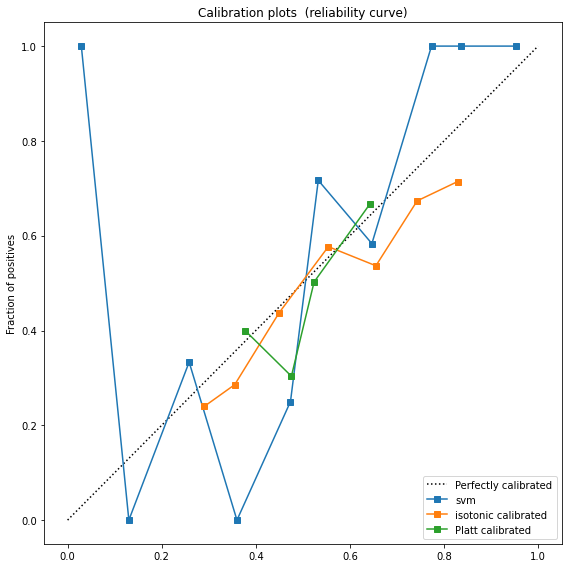

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_pos = svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='svm')

prob_pos = calibrated_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='isotonic calibrated')

prob_pos = calibrated_platt_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Platt calibrated')

plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()
plt.show()

## Kaggle

На скриншотах ниже показано как можно легко и просто поучаствовать в kaggle соревновании.

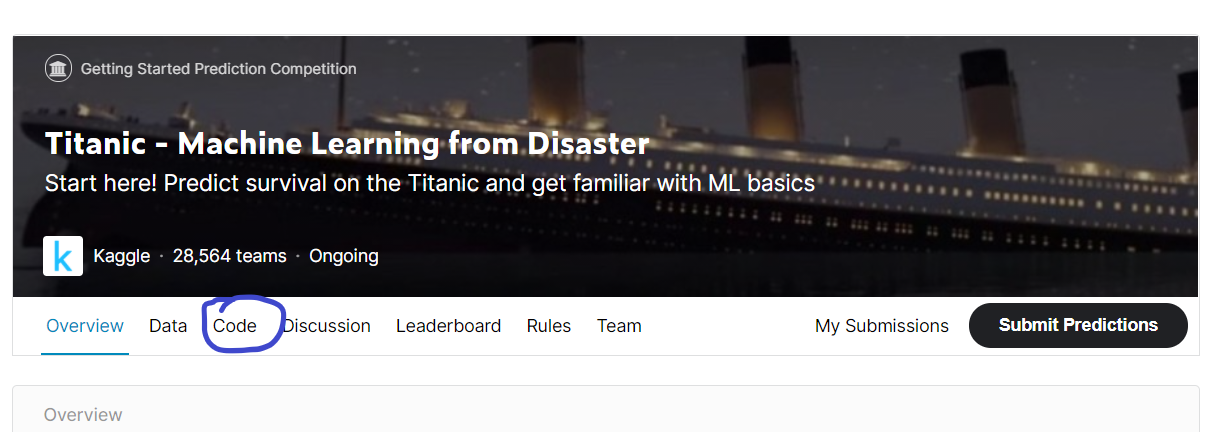

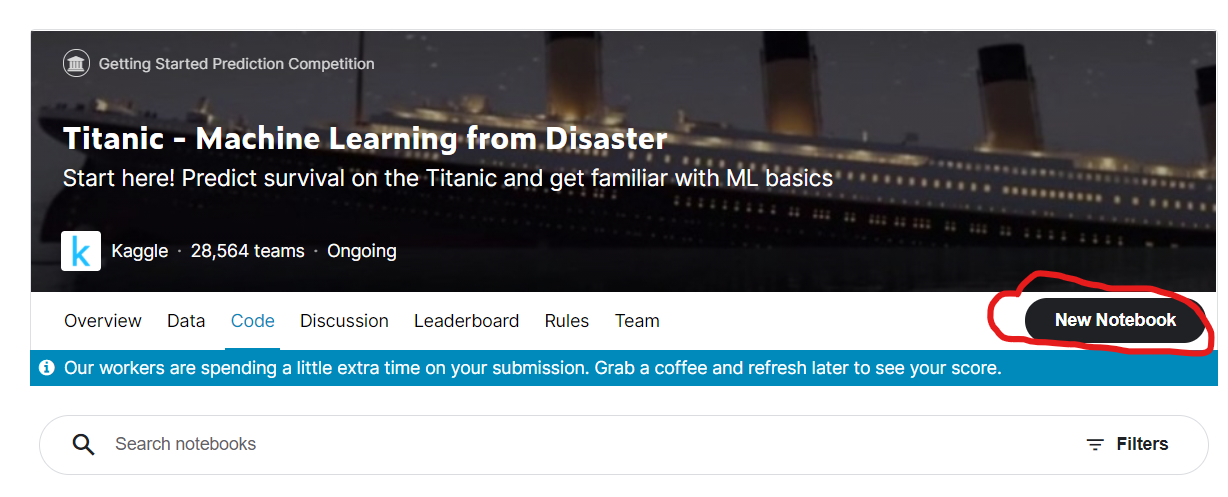

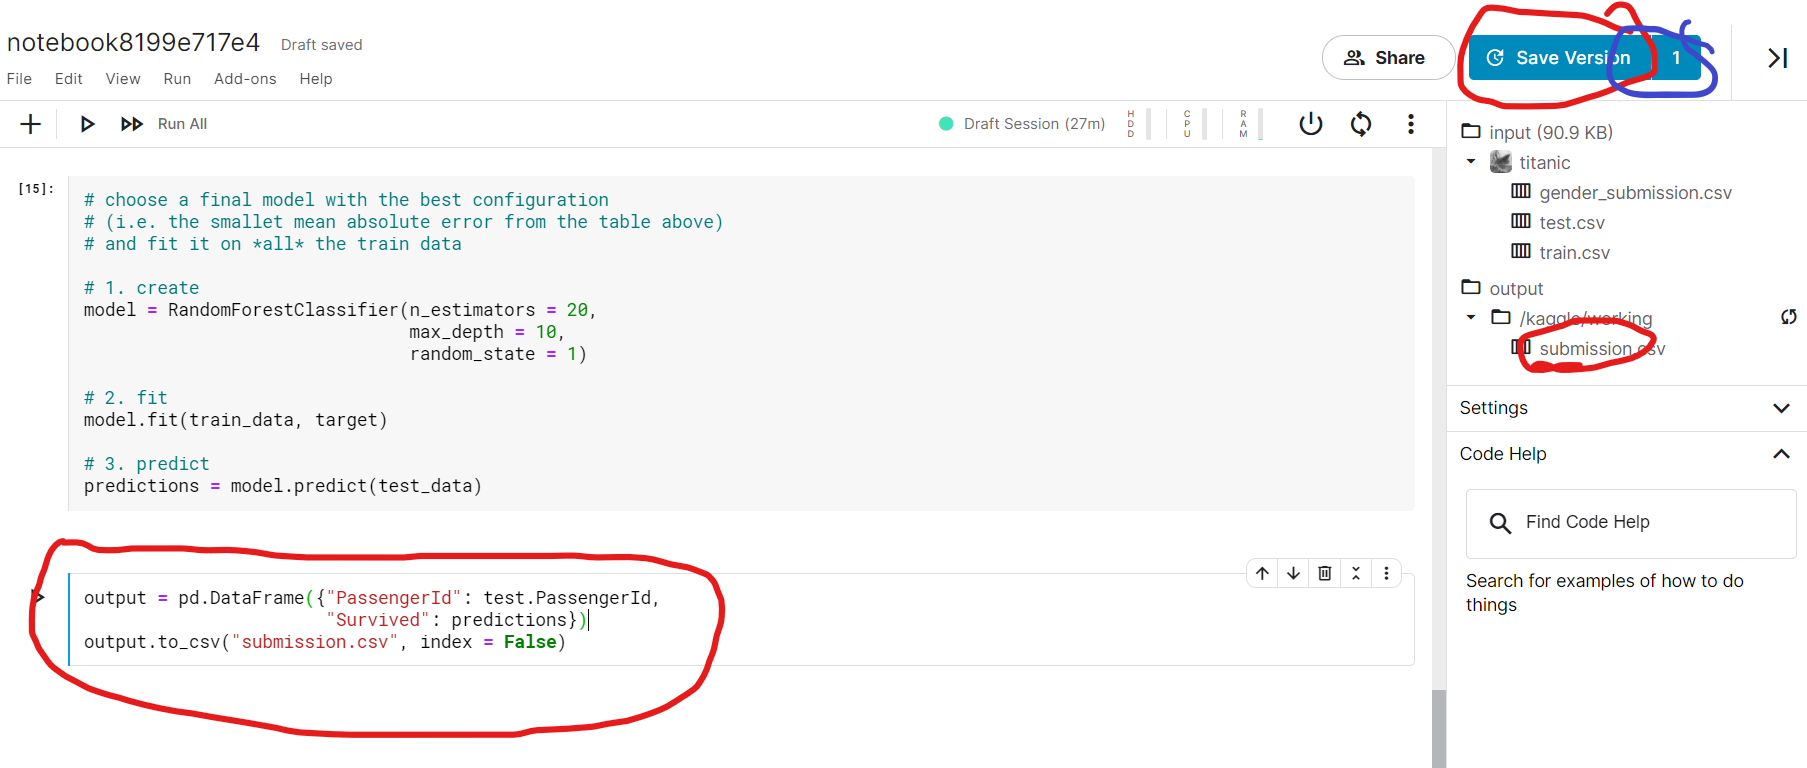

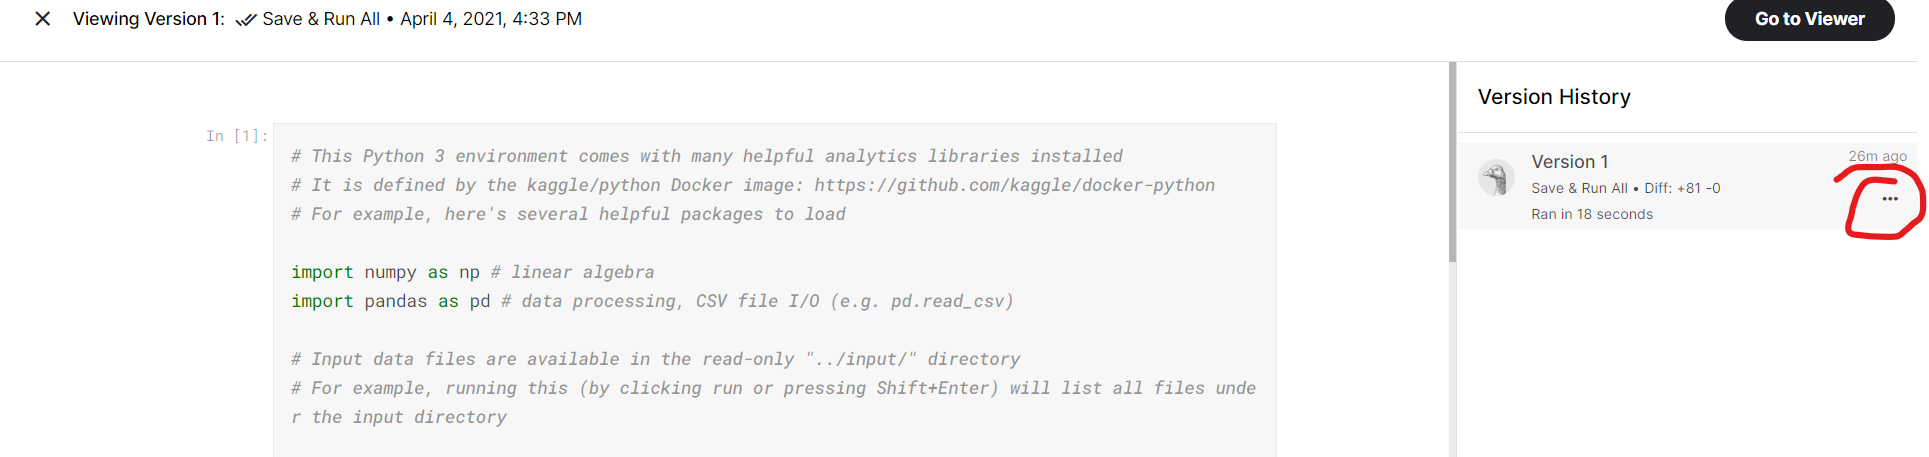

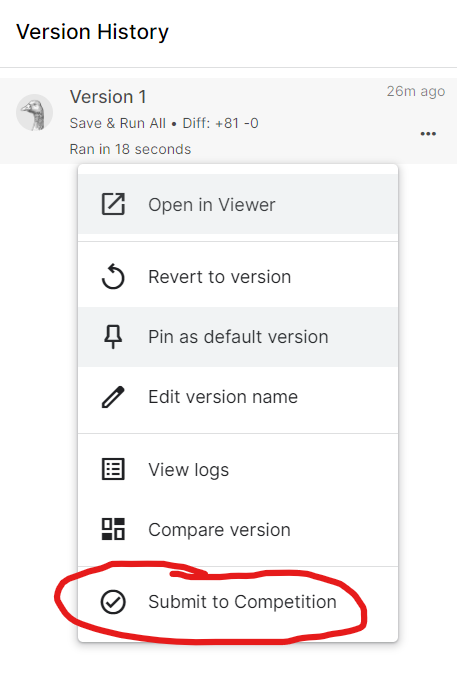

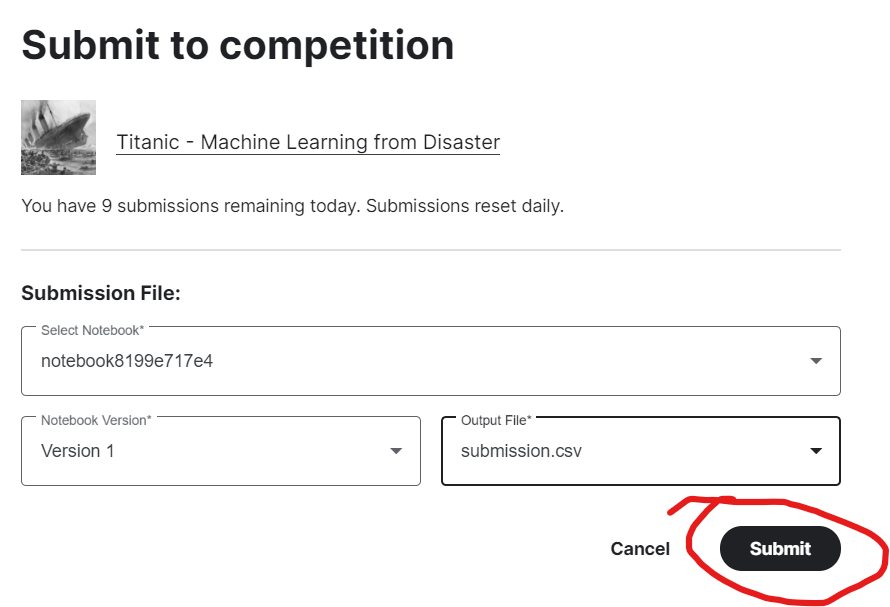

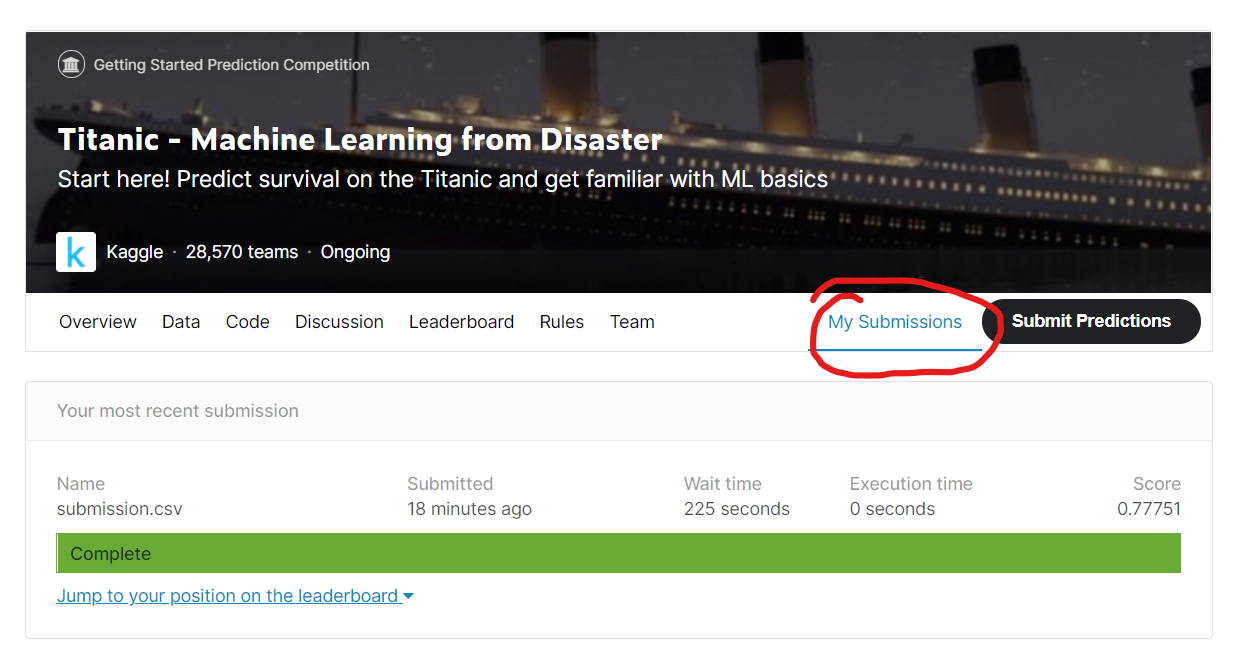